In [2]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, DMatrix
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import random
from conditionalconformal import CondConf
import itertools
import math
from matplotlib.patches import Patch
from scipy.spatial import ConvexHull

In [3]:
np.random.seed(1)
random.seed(1)

dimension_z = 100
dimension_x = 100
number_z = 30
# Generating 30 vectors, each with 100 dimensions
z_domain = np.random.normal(size=(number_z, dimension_z))

# Generating beta_1 and beta_2
beta_1 = np.random.uniform(-1, 1, dimension_x)
beta_2 = np.random.uniform(-1, 1, dimension_z)


In [4]:
def generate_function(beta_1, beta_2):


    def function_1(X, Z):
        epsilon = truncnorm.rvs(-1, 1)  # Generate epsilon from a truncated normal distribution
        T = (np.dot(beta_1.T, X) ** 2) * (np.sin(np.dot(beta_2.T, Z)) ** 2) + np.exp(np.cos(np.dot(X, Z))**2) * (epsilon)
        return T

    return function_1

function_1 = generate_function(beta_1, beta_2)

In [5]:
def prepare_data_for_regression(df):
    # Extracting X and Z and converting them into suitable format for regression
    X_data = np.array(df['X'].tolist())
    Z_data = np.array(df['Z'].tolist())

    # Concatenating X and Z
    combined_data = np.concatenate([X_data, Z_data], axis=1)

    return combined_data


In [6]:
def phi_fn(feature):
    scalar_values = np.array(feature[:,dimension_x:(dimension_x+dimension_z)])

    # Initialize the indicator matrix
    matrix = np.zeros((len(np.array(feature[:,1])), number_z))

    # Fill in the indicator matrix
    for i, value in enumerate(scalar_values):
        for j in range(0, number_z):
            if  np.array_equal(value, z_domain[j]):
                matrix[i, j] = 1

    return matrix

In [7]:
np.random.seed(1)
random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]

def conformal_predict_z_0(alpha=0.1, m=100, Z_new=Z_new, N=1000, t=200):
    IR = []
    for j in range(t):
        data_points = []
        for _ in range(N):
            # Randomly select a vector from z_domain to be Z
            Z = z_domain[np.random.randint(z_domain.shape[0])]

            # Compute the mean of the square of Z
            mean_x = np.mean(Z**2)

            # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 1
            X = np.random.normal(mean_x, 1, dimension_x)

            # Compute T_1 using the generated functions
            T_1 = function_1(X, Z)

            # Append the data point (X, Z, T_1) to the list
            data_points.append([X, Z, T_1])
        # Split the data into D_cali and D_train
        D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
        D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

        # Preparing data for regression
        X_train = prepare_data_for_regression(D_train)
        # Extracting T_1
        T_1_train = D_train['T_1']
        # Using a polynomial model 
        poly = PolynomialFeatures(degree=2)
        X_train_poly = poly.fit_transform(X_train)
        # Training the model
        model = LinearRegression()
        model.fit(X_train_poly, T_1_train)

        score_fn = lambda feature,  y : abs(y - model.predict(poly.transform(pd.DataFrame(feature))))
        
        condCovProgram = CondConf(score_fn, phi_fn, {})
        condCovProgram.setup_problem(prepare_data_for_regression(D_cali),D_cali['T_1'].to_numpy())
        
        data_points_new = []
        for _ in range(m):
            # Compute the mean of the square of Z
            mean_x_new = np.mean(Z_new**2)
            # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 1
            X_new = np.random.normal(mean_x_new, 1, dimension_x)
            # Compute T_1 using the generated functions
            T_1_new = function_1(X_new, Z_new)

            # Append the data point (X, Z, T_1) to the list
            data_points_new.append([X_new, Z_new, T_1_new])

        # Split the data into D_cali and D_train
        D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])
        
        X_neww = prepare_data_for_regression(D_new)
        T_1_new= D_new['T_1']
        X_new_poly = poly.transform(X_neww)
        T_1_pred_new = model.predict(X_new_poly)

        Xtest = np.array([prepare_data_for_regression(D_new)[10,:]])
        d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x) 
        
        # Calculate intervals
        hat_t_L = T_1_pred_new - d
        hat_t_U = T_1_pred_new + d 
        IR.append(np.mean((hat_t_L <= T_1_new) & (T_1_new <= hat_t_U)))
        
            
    return IR, d


In [7]:
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
IR_1000, d_1000 = conformal_predict_z_0(alpha=0.1, m=50, Z_new=Z_new, N=1000, t=1000)

np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
IR_3000, d_3000 = conformal_predict_z_0(alpha=0.1, m=50, Z_new=Z_new, N=3000, t=1000)

np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
IR_5000, d_5000 = conformal_predict_z_0(alpha=0.1, m=50, Z_new=Z_new, N=5000, t=1000)

np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
IR_7000, d_7000 = conformal_predict_z_0(alpha=0.1, m=50, Z_new=Z_new, N=7000, t=1000)

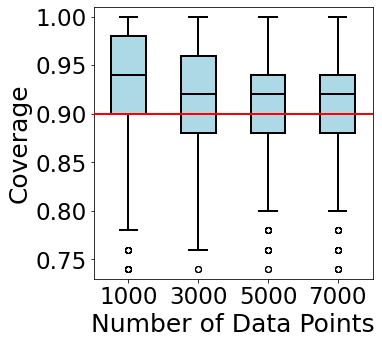

In [14]:
N_values = [1000, 3000, 5000, 7000]


fig = plt.figure(figsize=(5, 5))
plt.boxplot([IR_1000, IR_3000, IR_5000, IR_7000], patch_artist=True, 
            medianprops=dict(color="black", linewidth=2,zorder=4),  
            boxprops=dict(facecolor='lightblue', linewidth=2),  
            whiskerprops=dict(linewidth=2),  
            capprops=dict(linewidth=2),widths=0.5, labels=N_values)  

plt.yticks( fontsize=23)
plt.xticks([1], [''])  # Setting x-axis label to an empty string

plt.xlabel("Number of Data Points", fontsize=25)
plt.ylabel('Coverage', fontsize=25)
plt.xticks(range(1, len(N_values) + 1), N_values, fontsize=23)
plt.ylim(0.73,1.01)
plt.axhline(y=0.9, color='red', linestyle='-', label='', linewidth=2,zorder=3)

In [8]:
def create_coordinates(v):
    m = len(v)
    coordinates = np.zeros((m, 2))  

    for j in range(m):
        coordinates[j, 0] = (2 * j + 1) / (2 * m) 
        coordinates[j, 1] = (2 * j + 1) * v[j] / (2 * m)  

    return coordinates

def get_slope(x, hull_points, slopes):
    for i in range(len(hull_points) - 1):
        x1, x2 = hull_points[i][0], hull_points[i + 1][0]
        if x1 <= x <= x2:
            if x == x2 and i < len(slopes) - 1:
                return max(slopes[i], slopes[i + 1])
            if x == x1 and i > 0:
                return max(slopes[i - 1], slopes[i])
            return slopes[i]
    return None


def find_last_min_non_negative_index(nums):
    min_non_neg = float('inf')  
    min_index = -1 
    for i, num in enumerate(nums):
        if num >= 0 and num <= min_non_neg:
            min_non_neg = num
            min_index = i

    return min_index



def myerson_reserve(table):
    sorted_bids = np.sort(table["T_1"])[::-1]  
    
    new_vector_1 = create_coordinates(sorted_bids)
    new_points = np.array([[0, 0], [1, 0]])
    new_vector_1 = np.concatenate((new_points[0:1], new_vector_1, new_points[1:2]), axis=0)
    points = new_vector_1
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]

    hull_points = hull_points[hull_points[:, 0].argsort()]

    slopes = []
    for i in range(len(hull_points) - 1):
        x1, y1 = hull_points[i]
        x2, y2 = hull_points[i + 1]
        slope = (y2 - y1) / (x2 - x1)
        slopes.append(slope)

    point_slopes = []
    for point in points:
        x = point[0]
        slope = get_slope(x, hull_points, slopes)
        point_slopes.append(slope)
        
    index_reserve = find_last_min_non_negative_index(point_slopes[1:-1])
    return sorted_bids[index_reserve]


In [10]:
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
def conformal_predict(alpha=0.1, m=100, Z_new=Z_new, reserve_price=0):
   

    score_fn = lambda feature,  y : abs(y - model.predict(poly.transform(pd.DataFrame(feature))))

    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(prepare_data_for_regression(D_cali),D_cali['T_1'].to_numpy())

    data_points_new = []
    for _ in range(m):
        # Compute the mean of the square of Z
        mean_x_new = np.mean(Z_new**2)
        # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X_new = np.random.normal(mean_x_new, 1, dimension_x)
        # Compute T_1 using the generated functions
        T_1_new = function_1(X_new, Z_new)

        # Append the data point (X, Z, T_1) to the list
        data_points_new.append([X_new, Z_new, T_1_new])

    # Split the data into D_cali and D_train
    D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])

    X_neww = prepare_data_for_regression(D_new)
    T_1_new= D_new['T_1']
    X_new_poly = poly.transform(X_neww)
    T_1_pred_new = model.predict(X_new_poly)

    Xtest = np.array([prepare_data_for_regression(D_new)[10,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x) 
     
    reserve_price = T_1_pred_new - d
    virtual_value = np.array(T_1_new) * (np.array(T_1_new) > reserve_price)

    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]
    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(np.array(T_1_new))
    
    sb_value = np.sort(np.array(T_1_new))[::-1][1] if len(np.sort(np.array(T_1_new))[::-1]) >= 2 else 0
    myerson_value = np.maximum(np.sort(np.array(T_1_new))[::-1][1], myerson_reserve_price) if np.sort(np.array(T_1_new))[::-1][0] >= myerson_reserve_price else 0

    
    return payment, myerson_value, sb_value, max_welfare

In [12]:
np.random.seed(1)
random.seed(1)
N_values = [1000, 3000, 5000, 7000, 9000, 11000, 13000]
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
num_runs = 1000

# Initializes the dictionary used to store the results
results_list = []  

# For each value of N, run the function 1000 times and calculate the average
for N in N_values:
    data_points = []
    for _ in range(N):
        # Randomly select a vector from z_domain to be Z
        Z = z_domain[np.random.randint(z_domain.shape[0])]

        # Compute the mean of the square of Z
        mean_x = np.mean(Z**2)

        # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X = np.random.normal(mean_x, 1, dimension_x)

        # Compute T_1 using the generated functions
        T_1 = function_1(X, Z)

        # Append the data point (X, Z, T_1) to the list
        data_points.append([X, Z, T_1])
    # Split the data into D_cali and D_train
    D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
    D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])
    
    ############################################## The Empirical Myerson Auction
    D_myerson = pd.DataFrame(data_points, columns=["X", "Z", "T_1"])
    df_myerson =  D_myerson[D_myerson["Z"].apply(lambda z: np.array_equal(z, Z_new))]
    myerson_reserve_price = myerson_reserve(df_myerson)
    ##############################################
    
    # Preparing data for regression
    X_train = prepare_data_for_regression(D_train)
    # Extracting T_1
    T_1_train = D_train['T_1']
    # Using a polynomial model 
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    # Training the model
    model = LinearRegression()
    model.fit(X_train_poly, T_1_train)

    payments, myerson_values, sb_values, max_welfares = [], [], [], []
    for _ in range(num_runs):
        payment, myerson_value, sb_value, max_welfare = conformal_predict(0.1, 50, Z_new, myerson_reserve_price)
        payments.append(payment)
        myerson_values.append(myerson_value)
        sb_values.append(sb_value)
        max_welfares.append(max_welfare)
     # Store the results for each N in a separate dictionary
    results = {"N": N, "payment": payments, "myerson_values": myerson_values, "sb_value": sb_values, "max_welfare":max_welfares}
    results_list.append(results)


In [7]:
N_values = []
payments_means, payments_stds = [], []
sb_values_means, sb_values_stds = [], []
max_welfare_means, max_welfare_stds = [], []
myerson_means, myerson_stds = [], []


for entry in results_list:
    N_values.append(entry['N'])
    payments_means.append(np.mean(entry['payment']))
    payments_stds.append(1.96*np.std(entry['payment']) / np.sqrt(len(entry['payment'])))
    sb_values_means.append(np.mean(entry['sb_value']))
    sb_values_stds.append(1.96*np.std(entry['sb_value']) / np.sqrt(len(entry['sb_value'])))
    max_welfare_means.append(np.mean(entry['max_welfare']))
    max_welfare_stds.append(1.96*np.std(entry['max_welfare']) / np.sqrt(len(entry['max_welfare'])))
    myerson_means.append(np.mean(entry['myerson_values']))
    myerson_stds.append(1.96*np.std(entry['myerson_values']) / np.sqrt(len(entry['myerson_values'])))

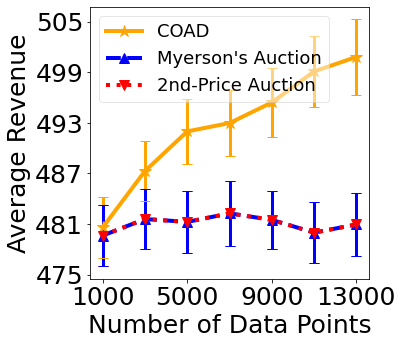

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))

plt.plot(N_values, payments_means,label="COAD", color='orange', linestyle='-', marker='*', linewidth=4,markersize=12)
plt.plot(N_values, myerson_means, label="Myerson's Auction", color='blue', linestyle='--', marker='^', linewidth=4,markersize=10)
plt.plot(N_values, sb_values_means, label="2nd-Price Auction", color='red', linestyle=':', marker='v', linewidth=4,markersize=10)

plt.errorbar(N_values, payments_means, yerr=payments_stds, fmt='none', ecolor='orange', capsize=5, elinewidth=3)
plt.errorbar(N_values, sb_values_means, yerr=sb_values_stds, fmt='none', ecolor='red',capsize=5, elinewidth=3)
plt.errorbar(N_values, myerson_means, yerr=myerson_stds, fmt='none', ecolor='blue',capsize=5, elinewidth=3)

plt.xlabel("Number of Data Points", fontsize=25)
plt.ylabel("Average Revenue", fontsize=25)
plt.legend(fontsize=18, facecolor='white', framealpha=0.5)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.xticks([1000, 5000, 9000, 13000])
plt.yticks([475, 481, 487, 493, 499, 505])
plt.show()

In [9]:
np.random.seed(1)
random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
data_points = []
N = 20000
for _ in range(N):
    # Randomly select a vector from z_domain to be Z
    Z = z_domain[np.random.randint(z_domain.shape[0])]

    # Compute the mean of the square of Z
    mean_x = np.mean(Z**2)

    # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 1
    X = np.random.normal(mean_x, 1, dimension_x)

    # Compute T_1 using the generated functions
    T_1 = function_1(X, Z)

    # Append the data point (X, Z, T_1) to the list
    data_points.append([X, Z, T_1])
# Split the data into D_cali and D_train
D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

############################################## The Empirical Myerson Auction
D_myerson = pd.DataFrame(data_points, columns=["X", "Z", "T_1"])
df_myerson =  D_myerson[D_myerson["Z"].apply(lambda z: np.array_equal(z, Z_new))]
myerson_reserve_price = myerson_reserve(df_myerson)
##############################################
    
    
# Preparing data for regression
X_train = prepare_data_for_regression(D_train)
# Extracting T_1
T_1_train = D_train['T_1']
# Using a polynomial model 
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
# Training the model
model = LinearRegression()
model.fit(X_train_poly, T_1_train)
def conformal_predict(alpha=0.1, m=100, Z_new=Z_new, reserve_price=myerson_reserve_price):
   

    score_fn = lambda feature,  y : abs(y - model.predict(poly.transform(pd.DataFrame(feature))))

    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(prepare_data_for_regression(D_cali),D_cali['T_1'].to_numpy())

    data_points_new = []
    for _ in range(m):
        # Compute the mean of the square of Z
        mean_x_new = np.mean(Z_new**2)
        # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X_new = np.random.normal(mean_x_new, 1, dimension_x)
        # Compute T_1 using the generated functions
        T_1_new = function_1(X_new, Z_new)

        # Append the data point (X, Z, T_1) to the list
        data_points_new.append([X_new, Z_new, T_1_new])

    # Split the data into D_cali and D_train
    D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])

    X_neww = prepare_data_for_regression(D_new)
    T_1_new= D_new['T_1']
    X_new_poly = poly.transform(X_neww)
    T_1_pred_new = model.predict(X_new_poly)

    Xtest = np.array([prepare_data_for_regression(D_new)[1,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x) 
     
    reserve_price = T_1_pred_new - d
    virtual_value = np.array(T_1_new) * (np.array(T_1_new) > reserve_price)

    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]
    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(np.array(T_1_new))
    
    sb_value = np.sort(np.array(T_1_new))[::-1][1] if len(np.sort(np.array(T_1_new))[::-1]) >= 2 else 0
    myerson_value = np.maximum(np.sort(np.array(T_1_new))[::-1][1], myerson_reserve_price) if np.sort(np.array(T_1_new))[::-1][0] >= myerson_reserve_price else 0

    
    return payment, myerson_value, sb_value, max_welfare

In [10]:

m_values = list(range(50, 301, 50))
np.random.seed(1)
random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
num_runs = 1000

# This will store the results for each m value
results_list_m = []

# For each m value, run the function 1000 times and calculate the average
for m in m_values:
    payments, myerson_values, sb_values, max_welfares = [], [], [], []
    for _ in range(num_runs):
        payment, myerson_value, sb_value, max_welfare = conformal_predict(0.1, m, Z_new)
        payments.append(payment)
        myerson_values.append(myerson_value)
        sb_values.append(sb_value)
        max_welfares.append(max_welfare)
    
    # Create a dictionary for each m with the results and append to the list
    results = {"m": m, "payment": payments, "myerson_values": myerson_values, "sb_value": sb_values, "max_welfare": max_welfares}
    results_list_m.append(results)
    


In [11]:
m_values = []
payment_means = []
payment_ses = []
sb_value_means = []
sb_value_ses = []
max_welfare_means = []
max_welfare_ses = []
myerson_means, myerson_ses = [], []

for entry in results_list_m:
    m_values.append(entry['m'])
    payment_means.append(np.mean(entry['payment']))
    payment_ses.append(1.96 * np.std(entry['payment']) / np.sqrt(len(entry['payment'])))
    sb_value_means.append(np.mean(entry['sb_value']))
    sb_value_ses.append(1.96 * np.std(entry['sb_value']) / np.sqrt(len(entry['sb_value'])))
    max_welfare_means.append(np.mean(entry['max_welfare']))
    max_welfare_ses.append(1.96 * np.std(entry['max_welfare']) / np.sqrt(len(entry['max_welfare'])))
    myerson_means.append(np.mean(entry['myerson_values']))
    myerson_ses.append(1.96*np.std(entry['myerson_values']) / np.sqrt(len(entry['myerson_values'])))

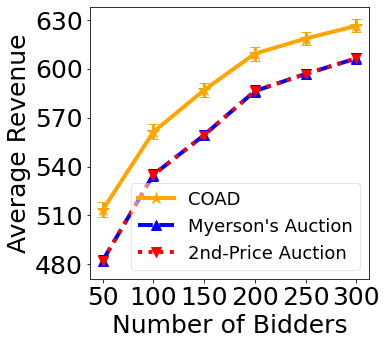

In [13]:

plt.figure(figsize=(5, 5))
plt.plot(m_values, payment_means, label="COAD",  color='orange', linestyle='-', marker='*', linewidth=4,markersize=12)
plt.plot(m_values, myerson_means, label="Myerson's Auction",  color='blue', linestyle='--', marker='^', linewidth=4,markersize=10)
plt.plot(m_values, sb_value_means, label="2nd-Price Auction",  color='red', linestyle=':', marker='v', linewidth=4,markersize=10)

plt.errorbar(m_values, payment_means, yerr=payment_ses, fmt='none', ecolor='orange', capsize=5, elinewidth=3)
plt.errorbar(m_values, sb_value_means, yerr=sb_value_ses,fmt='none', ecolor='red', capsize=5, elinewidth=3)
plt.errorbar(m_values, myerson_means, yerr=myerson_ses,fmt='none', ecolor='blue', capsize=5, elinewidth=3)


plt.xlabel("Number of Bidders", fontsize=25)
plt.ylabel("Average Revenue", fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks([480, 510,540,570,600, 630])
plt.title("")
plt.legend(fontsize=18, loc="lower right", facecolor='white', framealpha=0.5)
plt.show()
